In [29]:
# 1. Import thư viện cần thiết
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
import math

In [30]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('DOGE-USD.csv')
df1=df.reset_index()['Close']

In [31]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [32]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [33]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [34]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)


In [35]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [36]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [37]:
# 9. Fit mô hình với dữ liệu train
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 4s 119ms/step - loss: 0.0163 - val_loss: 9.4652e-04
Epoch 2/100
16/16 [==============================] - 2s 109ms/step - loss: 0.0021 - val_loss: 1.9348e-04
Epoch 3/100
16/16 [==============================] - 1s 78ms/step - loss: 0.0013 - val_loss: 8.3180e-05
Epoch 4/100
16/16 [==============================] - 1s 66ms/step - loss: 0.0012 - val_loss: 7.5404e-05
Epoch 5/100
16/16 [==============================] - 1s 71ms/step - loss: 0.0011 - val_loss: 8.2282e-05
Epoch 6/100
16/16 [==============================] - 1s 65ms/step - loss: 0.0011 - val_loss: 7.1514e-05
Epoch 7/100
16/16 [==============================] - 1s 66ms/step - loss: 0.0010 - val_loss: 1.8150e-04
Epoch 8/100
16/16 [==============================] - 1s 66ms/step - loss: 0.0010 - val_loss: 2.6917e-04
Epoch 9/100
16/16 [==============================] - 1s 66ms/step - loss: 9.9202e-04 - val_loss: 7.1797e-05
Epoch 10/100
16/16 [==============================] - 1s 6

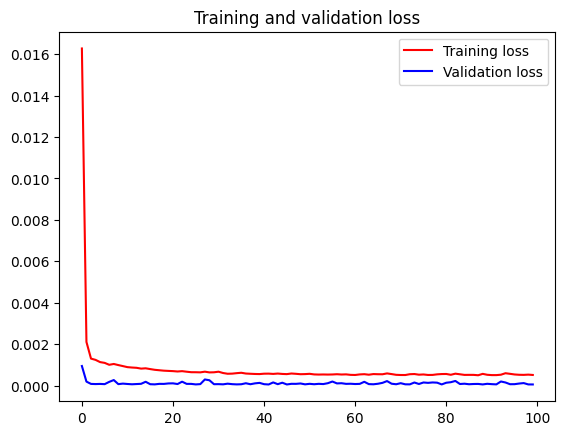

<Figure size 640x480 with 0 Axes>

In [38]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [39]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 21ms/step


In [40]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(y_pred)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
ytest = scaler.inverse_transform(ytest.reshape(-1,1)) 

In [41]:
mse = mean_squared_error(ytest,test_predict)
print('MSE:', mse)

MSE: 2.6375623950988896e-05


In [42]:
mae = mean_absolute_error(ytest,test_predict)
print('MAE:', mae)

MAE: 0.0032948996625231787


In [43]:
rmse = math.sqrt(mean_squared_error(ytest,test_predict))
print('Test_RMSE:', rmse)
rmse = math.sqrt(mean_squared_error(yval,y_pred_val))
print('Val_RMSE:', rmse)

Test_RMSE: 0.0051357203926020835
Val_RMSE: 0.035231230472616046


In [44]:
r2 = r2_score(ytest, test_predict)
print('test_r2:', r2)
r2 = r2_score(yval, y_pred_val)
print('val_r2:', r2)

test_r2: 0.9690948508037183
val_r2: -10.622270920727571


In [45]:
# def mape(y_test, pred):
#     y_test, pred = np.array(y_test), np.array(pred)
#     mape = np.mean(np.abs((y_test - pred) / y_test))
#     return mape
# mape = mape(ytest, test_predict)
# print('MAPE:', mape)


In [46]:
#TÍNH MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(ytest, y_pred)
print("Testing MAPE",test_mape)

val_mape = mean_absolute_percentage_error(yval, y_pred_val)
print("Validation MAPE",val_mape)

Testing MAPE 0.038879122429616324
Validation MAPE 0.30716253806670224


In [47]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=96
i=0
while(i<30):
    
    if(len(temp_input)>96):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.10840424]
97
1 day input [0.10565394 0.10076108 0.10172853 0.09786751 0.10063375 0.10053276
 0.10233154 0.10088841 0.10494116 0.10247204 0.10381857 0.10345559
 0.10547392 0.10866899 0.11151572 0.11213629 0.11525818 0.12133511
 0.12555764 0.12381301 0.12016129 0.11920409 0.11511914 0.11726919
 0.12421111 0.12181371 0.12699344 0.12743399 0.12062087 0.12449066
 0.1241672  0.12526491 0.12623822 0.12981676 0.12704174 0.13850184
 0.13558047 0.13090861 0.13384755 0.13793835 0.13254201 0.12881564
 0.133246   0.12970406 0.11700574 0.11643493 0.11831128 0.11797758
 0.11799514 0.120012   0.12843803 0.12222206 0.12620602 0.12790527
 0.12503513 0.12685294 0.12276213 0.12293923 0.12112142 0.11615684
 0.11598999 0.11806247 0.11682132 0.11593584 0.11771413 0.11560067
 0.11012236 0.10687167 0.10722147 0.10723611 0.10612815 0.10185733
 0.09432996 0.09410456 0.09521837 0.10166852 0.10465429 0.10720977
 0.10000732 0.10418155 0.10973011 0.10466747 0.10724782 0.10237984
 0.1102936  0.10605644 0.11105175 

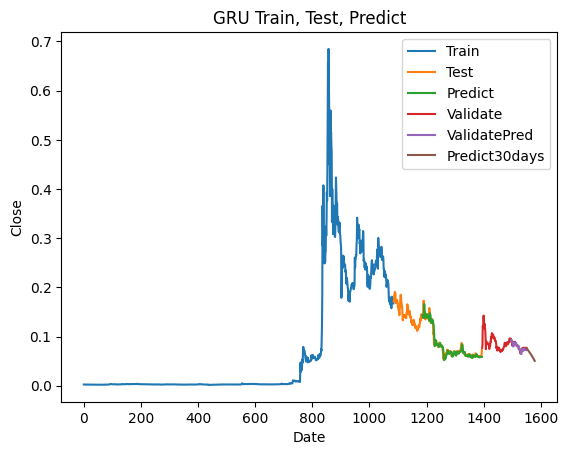

In [48]:
# 14.Vẽ hình
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('GRU Train, Test, Predict')
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()